In [7]:
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.next import particles
from particula.next.aerosol import Aerosol

from particula.next.gas.species_builders import PresetGasSpeciesBuilder
from particula.next.gas.atmosphere_builders import AtmosphereBuilder

from particula.next.dynamics import particle_process
from particula.next.dynamics import coagulation

from particula.util.input_handling import convert_units

In [8]:
# common parameters
mode = np.array([100e-9])
geometric_standard_deviation = np.array([1.3])
number_of_particles = np.array([1])  # effective when pdf has multiple modes
density = np.array([1.0e3])
volume = 1 * convert_units('m^-3', 'm^-3')  # cm^-3 to m^-3

# Preset gas species that does not condense in the atmosphere
# AtmosphereBuilder constructs the atmosphere with predefined species
atmosphere = (
    AtmosphereBuilder()
    .add_species(PresetGasSpeciesBuilder().build())  # Add a preset gas species
    .set_temperature(25, temperature_units="degC")  # Set temperature to 25°C
    .set_pressure(1, pressure_units="atm")  # Set pressure to 1 atmosphere
    .build()  # Finalize the atmosphere object
)

In [9]:
number_of_samples = 100_000  # Number of samples for particle distribution

# Generate a particle distribution using a lognormal sample distribution
# This distribution has a mean particle diameter (mode) and geometric standard deviation (GSD)
radii_sample= particles.properties.lognormal_sample_distribution(
    mode=mode,
    geometric_standard_deviation=geometric_standard_deviation,
    number_of_particles=number_of_particles,
    number_of_samples=number_of_samples,  # Number of samples for particle distribution
)

# Calculate the mass of each particle in the sample, assuming density of 1500 kg/m^3
particle_mass_sample = (
    4 / 3 * np.pi * radii_sample**3 * density
)  # Particle mass in kg
print(f"total mass: {np.sum(particle_mass_sample):.2e} kg")
# Build a resolved mass representation for each particle
# This defines how particle mass, activity, and surface are represented
resolved_masses = (
    particles.ResolvedParticleMassRepresentationBuilder()
    # Use specieated mass distribution, ideal mass activity, and volume surface strategy
    .set_distribution_strategy(particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(particles.ActivityIdealMass())
    .set_surface_strategy(particles.SurfaceStrategyVolume())
    .set_mass(particle_mass_sample, "kg")  # Assign mass of particles (in kg)
    .set_density(density, "kg/m^3")  # Set particle density
    .set_charge(0)  # Assume neutral particles with no charge
    .set_volume(volume)  # Set volume of particle distribution
    .build()  # Finalize the resolved mass representation
)

# Create an aerosol object with the defined atmosphere and resolved particles
aerosol_resolved = Aerosol(atmosphere=atmosphere, particles=resolved_masses)

# Print the properties of the aerosol
print(aerosol_resolved)
concentration = aerosol_resolved.particles[0].get_concentration()
total_number_concentration = np.sum(concentration)
print(f"Total number concentration: {total_number_concentration:.2e} m^-3")

# get distribution

distribution = aerosol_resolved.particles[0].get_distribution(clone=True)
print(f"size distribution: {distribution.shape}")
print(f"total mass: {np.sum(distribution):.2e} kg")

# alt


total mass: 5.69e-13 kg
Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']
[0]: Particle Representation (strategy=ParticleResolvedSpeciatedMass, activity=ActivityIdealMass, surface=SurfaceStrategyVolume, total mass=5.691427502289935e-13) 
Total number concentration: 1.00e+05 m^-3
size distribution: (100000,)
total mass: 5.69e-13 kg


In [10]:
# Build a resolved mass representation for each particle
# This defines how particle mass, activity, and surface are represented
radius_bins = np.logspace(-8, -6, 250)  # Define the radius bins for the resolved mass representation

number_concentration = np.array([number_of_samples/volume])  # Calculate the number concentration of particles

particle_pmf = (
    particles.PresetParticleRadiusBuilder()
    .set_mode(mode)
    .set_geometric_standard_deviation(geometric_standard_deviation)
    .set_number_concentration(number_concentration)
    .set_distribution_type('pmf')  # Set the distribution type to PMF
    .set_radius_bins(radius_bins, radius_bins_units="m")  # Set the radius bins
    .set_density(density, "kg/m^3")  # Set particle density
    .build()  # Finalize the resolved mass representation
)

# Create an aerosol object with the defined atmosphere and resolved particles
aerosol_pmf = Aerosol(atmosphere=atmosphere, particles=particle_pmf)

# Print the properties of the aerosol
print(aerosol_pmf)
total_number_concentration = np.sum(aerosol_pmf.particles[0].get_concentration())
print(f"Total number concentration: {total_number_concentration:.2e} particles/m^3")

Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']
[0]: Particle Representation (strategy=RadiiBasedMovingBin, activity=ActivityIdealMass, surface=SurfaceStrategyVolume, total mass=5.709717175552044e-13) 
Total number concentration: 1.00e+05 particles/m^3


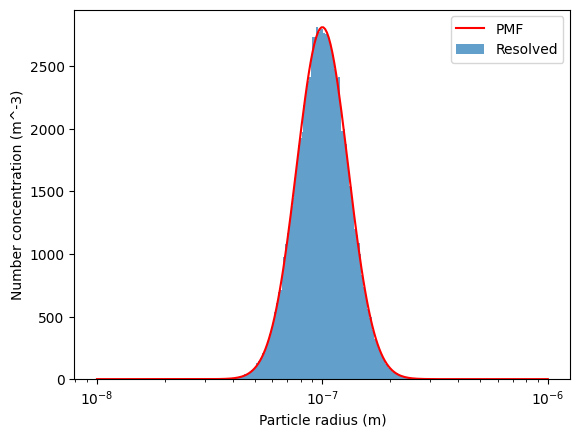

In [11]:
# plot both
radius_bins = particle_pmf.get_radius()
radii_resolved = resolved_masses.get_radius()

fig, ax = plt.subplots()
bins, edges = np.histogram(radii_resolved, bins=radius_bins)
ax.bar(
    edges[:-1],
    bins,
    width=np.diff(edges),
    align="edge",
    label="Resolved",
    alpha=0.7,
)
ax.plot(
    radius_bins,
    particle_pmf.get_concentration(),
    label="PMF",
    color="red",
)
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Number concentration (m^-3)")
ax.legend()
plt.show()

In [12]:
# simulate both aerosols, and save total mass and number distribution

# Define the coagulation process
coagulation_process_pmf = particle_process.Coagulation(
    coagulation_strategy=coagulation.DiscreteSimple()
)
coagulation_process_resolved = particle_process.Coagulation(
    coagulation_strategy=coagulation.ParticleResolved()
)

# Set up time and sub-steps for the coagulation process
total_time = 1000
time_step = 100
sub_steps = 10

# output arrays
time = np.arange(0, total_time, time_step)
total_mass_pmf = np.zeros_like(time, dtype=np.float64)
total_mass_resolved = np.ones_like(time, dtype=np.float64)
number_distribution_pmf = np.zeros((len(time), len(radius_bins)))
number_distribution_resolved = np.zeros((len(time), number_of_samples))


In [13]:
# Simulation loop

for i, t in enumerate(time):
    # Perform coagulation for the PMF aerosol
    aerosol_pmf = coagulation_process_pmf.execute(aerosol_pmf, time_step, sub_steps)
    total_mass_pmf[i] = aerosol_pmf.particles[0].get_total_mass()
    number_distribution_pmf[i, :] = aerosol_pmf.particles[0].get_concentration(clone=True)

    # Perform coagulation for the resolved aerosol
    aerosol_resolved = coagulation_process_resolved.execute(aerosol_resolved, time_step, sub_steps)
    total_mass_resolved[i] = aerosol_resolved.particles[0].get_total_mass()
    number_distribution_resolved[i, :] = aerosol_resolved.particles[0].get_concentration(clone=True)

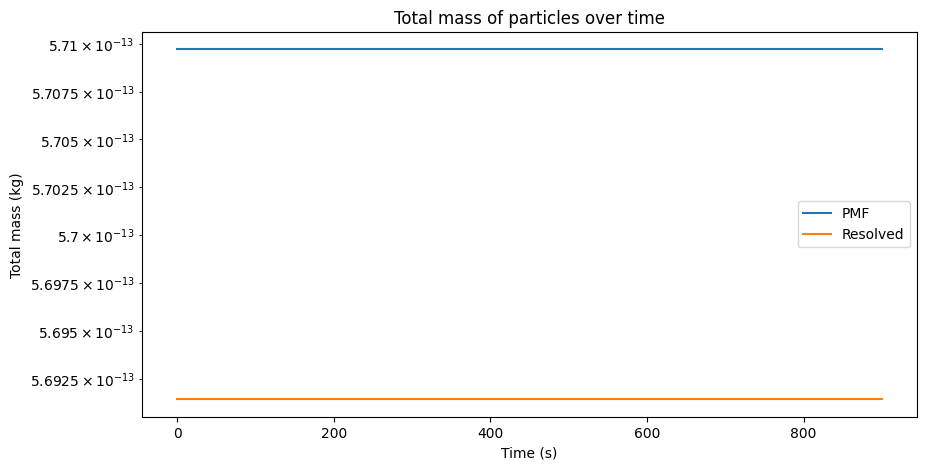

In [14]:
# plot results
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(time, total_mass_pmf, label="PMF")
ax.plot(time, total_mass_resolved, label="Resolved")

ax.set_yscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Total mass (kg)")
ax.set_title("Total mass of particles over time")
ax.legend()
plt.show()